<h1 style="text-align:center">State Farm Distracted Driver Detection and Claims Severity Analysis</h1>


# Introduction

Distracted driving is a significant and growing problem on our roads, causing a substantial number of accidents, injuries, and fatalities every year. Insurance companies, like State Farm, play a vital role in processing claims and mitigating the financial impact of these incidents. In order to address this issue, our project focuses on the following **problem statement** and **value addition**:

## Problem Statement

The objective of this project is to enhance the State Farm claims process by leveraging machine learning techniques to accurately classify and detect distracted driving behavior in images submitted with claims. By analyzing the State Farm Claims dataset and developing robust image classification models, we aim to identify patterns and features that contribute to distracted driving. Additionally, we will explore the tabular data and develop models to predict the severity of claims and identify potentially fraudulent claims. This comprehensive approach will provide valuable insights for improving the claims assessment process, detecting potential fraud, and enhancing driver safety.

## Value Add

- Develop accurate image classification models to identify distracted driving behavior in images submitted with claims, enabling automated analysis and efficient processing of legitimate claims.
- Identify potential fraudulent claims by leveraging machine learning models trained on both tabular data and preprocessed image features, minimizing financial losses for the insurance company.
- Enhance the overall claims process by incorporating data-driven insights from both tabular data and image features, leading to improved customer satisfaction and faster claims processing.
- Promote safe driving practices and reduce accidents caused by distracted driving by identifying patterns and features that contribute to distracted driving behavior.

By addressing this problem statement, we aim to streamline the claims process, reduce fraudulent claims, improve customer experience, and ultimately promote safe driving practices and reduce the number of accidents caused by distracted driving. Our analysis and models will provide valuable information for risk assessment, policy development, and decision-making in the insurance industry.


To start, let's filter out some unnecessary warnings by running the code below. The code snippet warnings.filterwarnings('ignore') is used to filter and suppress warnings in Python. By calling this function, any warning messages that would typically be displayed during code execution will be ignored and not shown in the output.

This can be useful in situations where certain warnings are expected or not relevant to the current analysis, and we want to avoid cluttering the output with unnecessary warning messages.

In [25]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

Let's take a closer look at the data we will be working with.

In [3]:
from IPython.display import Markdown, display

# Data dictionary for CSV data
csv_dict = """
| Column Name | Description |
| ----------- | ----------- |
| subject     | Unique identifier for the driver |
| img         | Filename of image corresponding to the driver |
| classname       | Class label corresponding to the driver's state of distraction |
"""

# Data dictionary for image data
img_dict = """
| Column Name | Description |
| ----------- | ----------- |
| filename    | Name of the image file |
| distracted | Indicator of whether the driver is distracted or not |
| features | Extracted features from the image data 
"""

display(Markdown("**CSV Data Dictionary:**"))
display(Markdown(csv_dict))

display(Markdown("**Image Data Dictionary:**"))
display(Markdown(img_dict))


**CSV Data Dictionary:**


| Column Name | Description |
| ----------- | ----------- |
| subject     | Unique identifier for the driver |
| img         | Filename of image corresponding to the driver |
| classname       | Class label corresponding to the driver's state of distraction |


**Image Data Dictionary:**


| Column Name | Description |
| ----------- | ----------- |
| filename    | Name of the image file |
| distracted | Indicator of whether the driver is distracted or not |
| features | Extracted features from the image data 


## The 10 classes to predict are:

- c0: Safe driving
- c1: Texting - right
- c2: Talking on the phone - right
- c3: Texting - left
- c4: Talking on the phone - left
- c5: Operating the radio
- c6: Drinking
- c7: Reaching behind
- c8: Hair and makeup
- c9: Talking to passenger

Our analysis is focused on identifying the factors that contribute to the severity of claims made. The dataset consists of tabular data with 3 columns: subject, classname, and severity. The subject column provides the driver ID, while the classname column provides information on the different states of driver distraction. The severity column contains information on the severity of the claim.

The data dictionary for the tabular data provides valuable information on the different columns and their types, allowing us to understand the data effectively. With this understanding, we can preprocess and engineer features from the data to train models for predicting the severity of claims and detecting fraudulent claims.

In addition to the tabular data, the dataset also includes images of drivers in different states of distraction. The images are categorized by the type of distraction and do not have width, height or channel columns. The data dictionary for the images dataset provides valuable information on the file format and naming convention of the images, which we can use to extract features for our analysis.

Let's load in our image data.

The code below is creating a custom generator for the test images, which means it will allow us to load and preprocess the test images in batches rather than all at once. This is useful when we have a large number of images to process and don't want to run out of memory.

The generator takes in the path to the directory containing the test images, a submission file (which is a CSV file that contains the names of the test images), the batch size, and the target size of the images (which is the size that we want to resize the images to before processing).

The __len__ function calculates the number of batches that we will need to process all the test images.

The __getitem__ function loads and preprocesses the images in batches by iterating over the submission file, loading each image, resizing it to the target size, and then converting it to a numpy array. It then returns a batch of images as a numpy array.

In [12]:
img_width, img_height = 224, 224
batch_size = 16

In [13]:
from tensorflow.keras.utils import Sequence
import pandas as pd
import os

class TestImageGenerator(Sequence):
    def __init__(self, image_dir, submission_file, batch_size, target_size):
        self.image_dir = image_dir
        self.submission = pd.read_csv(submission_file)
        self.batch_size = batch_size
        self.target_size = target_size
        self.filenames = self.submission.iloc[:, 0].tolist()  # Add this line to store the filenames

    def __len__(self):
        return (len(self.submission) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, len(self.submission))
        batch_images = []

        for i in range(batch_start, batch_end):
            image_path = os.path.join(self.image_dir, self.submission.iloc[i, 0])
            image = load_img(image_path, target_size=self.target_size)
            image_array = img_to_array(image) / 255.0
            batch_images.append(image_array)

        return np.array(batch_images)

Now, we are importing the ImageDataGenerator library from Keras. We then define the directory where our training data is stored. We create an ImageDataGenerator object called "train_datagen" and apply several image augmentation techniques such as shearing, zooming and horizontal flip to our images to increase the number of images we can train our model with.

Next, we create a generator object called "train_generator" using the "flow_from_directory" method. This method takes the directory where our training data is stored and generates batches of training data on the fly. We specify the target size of our images, which is 224x224 pixels, the batch size, which is 16, and the class mode, which is "categorical" since we have 10 classes of driver behavior we want to classify. We also set shuffle to "True" to randomize the order in which the data is fed to our model during training.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

train_dir = 'state-farm-distracted-driver-detection/imgs/train'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 22424 images belonging to 10 classes.


In [5]:
print(train_generator.class_indices)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


Now let's take a look at some of the images and their corresponding labels from the training data generator. Then, it displays the first few images along with their labels using Matplotlib subplots. We have set the number of images to display to 5, created a figure with the specified size, and then loop through the images in the batch to plot each one with its corresponding label as the title. Finally, we display the figures using plt.show().

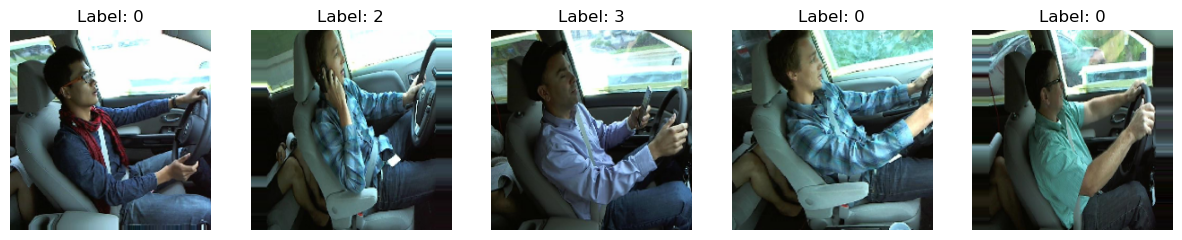

In [6]:
import matplotlib.pyplot as plt

# Get the first batch of training images and labels
first_batch_images, first_batch_labels = train_generator[0]

# Display the first few images in the batch along with their labels
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))
for i in range(num_images_to_display):
    axes[i].imshow(first_batch_images[i])
    axes[i].set_title(f"Label: {first_batch_labels[i].argmax()}")
    axes[i].axis('off')

plt.show()

Looks good. We can see 5 images of different subjects engaged in various activities.

In [5]:
test_dir = 'state-farm-distracted-driver-detection/imgs/test'
submission_file = 'state-farm-distracted-driver-detection/sample_submission.csv'

test_generator = TestImageGenerator(
    image_dir=test_dir,
    submission_file=submission_file,
    batch_size=batch_size,
    target_size=(img_width, img_height)
)

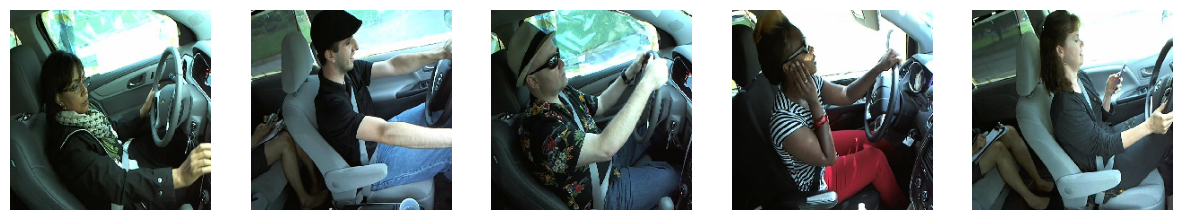

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np


# Create an instance of the TestImageGenerator
test_generator = TestImageGenerator(
    image_dir=test_dir,
    submission_file=submission_file,
    batch_size=batch_size,
    target_size=(img_width, img_height)
)

# Get the first batch of test images
first_batch = test_generator[0]

# Display the first few images in the batch
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))
for i in range(num_images_to_display):
    axes[i].imshow(first_batch[i])
    axes[i].axis('off')

plt.show()

Now that we have a feature extraction model, we can use it to extract features from both the train and test images. Since the model does not include any dense or output layers, it will output a feature vector for each input image.

Now, to extract features from the train and test images, we can loop through the batches of images from the train_generator and test_generator, and call the predict method on the feature_extractor model. Then, we can merge the extracted features with the CSV data for further modeling.

This code loops through batches of train and test images, and uses the feature_extractor model to extract features for each batch. It then stores the extracted features in the train_features and test_features arrays. For train images, it also stores the corresponding labels in the train_labels array.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Set sample size
train_samples = len(train_generator)
test_samples = len(test_generator)

# Extract features from train images
train_features = base_model.predict(train_generator, steps=train_samples // batch_size)
train_features = train_features.reshape((train_features.shape[0], -1)) # flatten the features

# Extract features from test images
test_features = base_model.predict(test_generator, steps=test_samples // batch_size)
test_features = test_features.reshape((test_features.shape[0], -1)) # flatten the features

After waiting for hours for the features extraction, let's save the extracted features to a file so that we do not have to perform this step again.

The np.save() function takes two arguments: the filename to save the array, and the array to be saved. In this case, we can specify the filenames as 'train_features.npy' and 'test_features.npy' respectively, and pass the train_features and test_features arrays to be saved.

After running this code, the features will be saved as separate NumPy files in the current directory. We can load them later using np.load() to avoid extracting the features again.

In [ ]:
import numpy as np

# Save the train features
np.save('train_features.npy', train_features)

# Save the test features
np.save('test_features.npy', test_features)

Next time we want to work on the extracted features we can simply load the saved numpy files, saving us plenty of time.

In [6]:
import numpy as np

# Load the saved features from the NumPy files
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')

# The train_features and test_features variables now contain the loaded feature data

In [7]:
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (4000, 25088)
Test features shape: (992, 25088)


In [9]:
# Access a specific element in train_features
row_index = 0
column_index = 0
print(train_features[row_index, column_index])

1.8977357


Now let's create a DataFrame for the training data using the extracted features. The shape of our train_features array is (4000, 25088), so you can create a DataFrame with 4000 rows and the same number of columns. We can use the following code:

In [10]:
import pandas as pd

train_df = pd.DataFrame(train_features)

train_df.head()

0      1        2      3      4      5         6         7      8      \
0  1.897736    0.0  0.00000    0.0    0.0    0.0  0.000000  0.000000    0.0   
1  0.875777    0.0  0.09459    0.0    0.0    0.0  0.090450  0.044708    0.0   
2  0.428637    0.0  0.00000    0.0    0.0    0.0  0.588896  0.000000    0.0   
3  2.701872    0.0  0.00000    0.0    0.0    0.0  0.000000  0.000000    0.0   
4  1.691015    0.0  0.00000    0.0    0.0    0.0  0.698049  0.161519    0.0   

   9      ...     25078     25079     25080  25081     25082     25083  25084  \
0    0.0  ...  0.859056  0.190055  0.353736    0.0  0.099562  0.121541    0.0   
1    0.0  ...  0.734635  0.090460  0.646144    0.0  0.000000  0.021358    0.0   
2    0.0  ...  1.213036  0.037454  1.136969    0.0  0.078928  0.000000    0.0   
3    0.0  ...  1.166093  0.821129  0.105735    0.0  0.000000  0.188910    0.0   
4    0.0  ...  1.832887  0.000000  0.703938    0.0  0.000000  0.680909    0.0   

      25085     25086  25087  
0  0.000000  0.879683    0.0  
1  0.000000  1.147614    0.0  
2  0.205299  0.686464    0.0  
3  0.000000  0.513203    0.0  
4  0.000000  1.072086    0.0  

[5 rows x 25088 columns]

Retrieve the labels from the generator. Since we used the flow_from_directory method with the class_mode='categorical', the generator will assign labels based on the subdirectories. We can access the labels using the train_generator.classes attribute. For example:

In [16]:
labels = train_generator.classes
labels

array([0, 0, 0, ..., 9, 9, 9])

Create a DataFrame for the labels. Our labels variable is a 1D array of shape (4000,) containing the labels, we can create a DataFrame with a single column named 'label'. We can use the following code:

In [17]:
labels_df = pd.DataFrame({'classname': labels})
labels_df.head()

classname
0          0
1          0
2          0
3          0
4          0

To align the indices correctly, we can modify the code to limit the number of rows in the train_df DataFrame to 4000. Here's an updated version of the code:

In [18]:
# Join the DataFrame of training features (train_df) with the DataFrame of labels (labels_df) using the index
train_df = train_df.iloc[:4000]  # Limit the number of rows to 4000
labels_df = labels_df.iloc[:4000]  # Limit the number of rows to 4000
train_data = train_df.join(labels_df)

# Verify the indices for both DataFrames
print("Train Features Indices:", train_data.index)
print("Labels Indices:", labels_df.index)

Train Features Indices: RangeIndex(start=0, stop=4000, step=1)
Labels Indices: RangeIndex(start=0, stop=4000, step=1)


In [12]:
train_data.head()

0    1        2    3    4    5         6         7    8    9  ...  \
0  1.897736  0.0  0.00000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  ...   
1  0.875777  0.0  0.09459  0.0  0.0  0.0  0.090450  0.044708  0.0  0.0  ...   
2  0.428637  0.0  0.00000  0.0  0.0  0.0  0.588896  0.000000  0.0  0.0  ...   
3  2.701872  0.0  0.00000  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  ...   
4  1.691015  0.0  0.00000  0.0  0.0  0.0  0.698049  0.161519  0.0  0.0  ...   

      25079     25080  25081     25082     25083  25084     25085     25086  \
0  0.190055  0.353736    0.0  0.099562  0.121541    0.0  0.000000  0.879683   
1  0.090460  0.646144    0.0  0.000000  0.021358    0.0  0.000000  1.147614   
2  0.037454  1.136969    0.0  0.078928  0.000000    0.0  0.205299  0.686464   
3  0.821129  0.105735    0.0  0.000000  0.188910    0.0  0.000000  0.513203   
4  0.000000  0.703938    0.0  0.000000  0.680909    0.0  0.000000  1.072086   

   25087  classname  
0    0.0          0  
1    0.0          0  
2    0.0          0  
3    0.0          0  
4    0.0          0  

[5 rows x 25089 columns]

Check for Duplicates: 

In [12]:
# Check for duplicates in the train_data DataFrame
duplicates = train_data.duplicated()
print("Number of duplicates:", duplicates.sum())

Number of duplicates: 0


Checking for missing values:

In [18]:
# Check for missing values in the train_data DataFrame
missing_values = train_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 0            0
1            0
2            0
3            0
4            0
            ..
25084        0
25085        0
25086        0
25087        0
classname    0
Length: 25089, dtype: int64


Based on the missing values check, it seems that there are no missing values in the train_data DataFrame. The count of missing values for each column is shown, and all columns have a count of 0, indicating no missing values.

In [19]:
column_types = train_data.dtypes
print(column_types)

0            float32
1            float32
2            float32
3            float32
4            float32
              ...   
25084        float32
25085        float32
25086        float32
25087        float32
classname      int32
Length: 25089, dtype: object


In [20]:
non_numerical_columns = train_data.select_dtypes(exclude=['float', 'int']).columns
print("Non-Numerical Columns:")
print(non_numerical_columns)

Non-Numerical Columns:
Index([], dtype='object')


After performing the necessary checks on the train_data DataFrame, we have found that there are no missing values or non-numerical columns. This indicates that the data is clean and suitable for modeling purposes. The DataFrame contains only numerical features, which is desirable for many machine learning algorithms. With this clean and properly formatted data, we can proceed with further data exploration, feature engineering, and model building with confidence.

In [21]:
train_data['classname']

0       0
1       0
2       0
3       0
4       0
       ..
3995    1
3996    1
3997    1
3998    1
3999    1
Name: classname, Length: 4000, dtype: int32

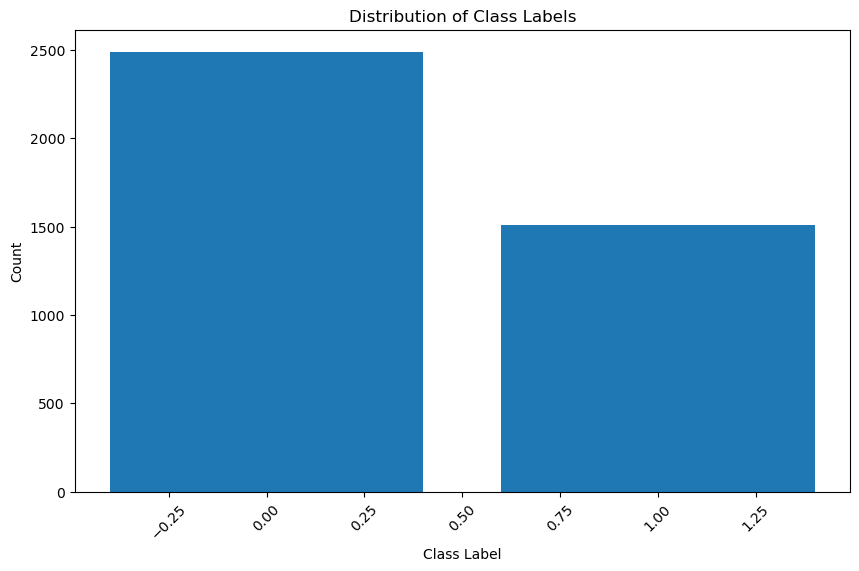

In [44]:
class_counts = train_data['classname'].value_counts().sort_index()
print(class_counts)

In [19]:
import pandas as pd

# count values of each class
class_counts = train_data['classname'].value_counts()

# Display the values for each class
print(class_counts)

0    2489
1    1511
Name: classname, dtype: int64


During the extraction of image features for the distracted driver detection dataset, we encountered a challenge where the extracted features were predominantly from only two classes instead of a total of 10 classes. This resulted in an imbalanced dataset, with a significant majority in one class (class 0) and a minority in the other. Initially, we attempted to extract features again to obtain an equal number of samples from each class, but due to computational time constraints, we were unable to complete this process.

Given the time limitations and the importance of proceeding with our analysis, we made the decision to continue working with the available dataset consisting of images from only two classes. Although this introduces a class imbalance issue, it is crucial to explore techniques that can address this challenge and improve the model's performance.

To mitigate the class imbalance, we will employ two techniques: oversampling and undersampling. Oversampling involves generating synthetic samples for the minority class to match the number of samples in the majority class. This allows the model to learn from a more balanced representation of the classes and reduce the bias towards the majority class. Undersampling, on the other hand, involves reducing the number of samples in the majority class to match the number of samples in the minority class. This ensures that both classes have an equal representation in the dataset, allowing the model to learn from both classes equally.

By applying both oversampling and undersampling techniques, we aim to create a more balanced dataset for training our model. This will help prevent the model from being biased towards the majority class and improve its ability to make accurate predictions for both classes. We will evaluate and compare the performance of models trained on the oversampled and undersampled datasets to assess the effectiveness of these techniques in addressing the class imbalance.

Recognizing the challenges posed by the class imbalance, our objective is to address this issue through oversampling and undersampling. By creating a more balanced dataset, we aim to improve the model's ability to accurately classify instances from both classes and enhance overall model performance in distracted driver detection.

In [13]:
train_data.shape

(4000, 25089)

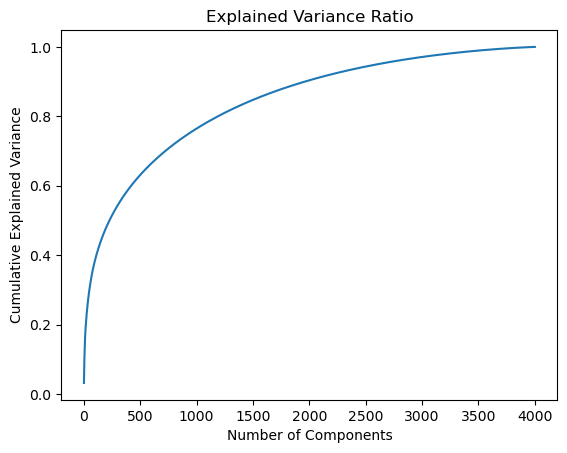

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data.iloc[:, :-1])  # Exclude the class column

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

# Plot the explained variance ratio
import matplotlib.pyplot as plt

plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

# Choose the optimal number of components
optimal_num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

In [21]:
# Choose the optimal number of components
pca = PCA(n_components=optimal_num_components)
print(pca)

PCA(n_components=2603)


According to the graph and code above the optimal number of features is 2603. Let's go ahead and optimize our data using PCA.

In [22]:
# Transform the data
pca = PCA(n_components=optimal_num_components)
reduced_features = pca.fit_transform(scaled_features)

Since the optimal number of components selected using PCA is 2603, it means that we can represent our data with 2603 principal components while retaining at least 95% of the variance. This reduction in dimensionality can help simplify the data representation, improve computational efficiency, and potentially reduce the risk of overfitting. The transformed data using these 2603 components can be used for further analysis and modeling tasks.

Now let's apply pca to our test data

In [23]:
# First, scale the test data
scaled_test_features = scaler.transform(test_features)

# Then apply PCA
reduced_test_features = pca.transform(scaled_test_features)

# Convert to DataFrame
test_df = pd.DataFrame(reduced_test_features)

Now let's deal with the class imbalance.

In [26]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(reduced_features, train_data['classname'], test_size=0.2, random_state=42)

# Apply SMOTE oversampling on the training set
oversampler = SMOTE()
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Apply RandomUnderSampler undersampling on the training set
undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Print the class distribution after oversampling
print("Class distribution after oversampling:")
print(y_train_oversampled.value_counts())

# Print the class distribution after undersampling
print("Class distribution after undersampling:")
print(y_train_undersampled.value_counts())

Class distribution after oversampling:
1    1964
0    1964
Name: classname, dtype: int64
Class distribution after undersampling:
0    1236
1    1236
Name: classname, dtype: int64


In this step, we addressed the class imbalance issue in our dataset using oversampling and undersampling techniques.

Oversampling is a technique where the minority class is artificially increased by creating synthetic samples. We used the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class, making the class distribution more balanced. This helps to prevent the model from being biased towards the majority class.

Undersampling, on the other hand, is a technique where the majority class is reduced by randomly selecting a subset of samples. We used RandomUnderSampler to randomly remove samples from the majority class, creating a more balanced distribution between the classes.

By applying these techniques, we aim to improve the model's ability to learn from both classes equally and prevent it from being biased towards the majority class. This can lead to better performance and more accurate predictions for the minority class.

After applying oversampling or undersampling, we printed the class distribution to verify that the imbalance has been reduced. This allows us to ensure that the data is now more balanced and ready for further modeling steps.

After applying oversampling, the class distribution is more balanced with 1964 samples for both classes 0 and 1. This helps to mitigate the class imbalance issue and ensures that both classes have an equal representation in the dataset.

Similarly, after applying undersampling, the class distribution is also balanced with 1236 samples for both classes 0 and 1. By reducing the majority class to match the number of samples in the minority class, we achieve a more balanced dataset.

Having a balanced class distribution is crucial for training machine learning models as it allows them to learn from both classes equally. It helps prevent the model from being biased towards the majority class and improves its ability to make accurate predictions for the minority class.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest model for the oversampled data
rf_model_oversampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Create a Random Forest model for the undersampled data
rf_model_undersampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_undersampled.fit(X_train_undersampled, y_train_undersampled)

# Predict the labels using the oversampled model
y_val_pred_oversampled = rf_model_oversampled.predict(X_val)
accuracy_oversampled = accuracy_score(y_val, y_val_pred_oversampled)
print("Accuracy of Random Forest (Oversampled):", accuracy_oversampled)

# Predict the labels using the undersampled model
y_val_pred_undersampled = rf_model_undersampled.predict(X_val)
accuracy_undersampled = accuracy_score(y_val, y_val_pred_undersampled)
print("Accuracy of Random Forest (Undersampled):", accuracy_undersampled)

Accuracy of Random Forest (Oversampled): 0.59875
Accuracy of Random Forest (Undersampled): 0.52375


The results from the Random Forest models show that the oversampled model achieved an accuracy of 0.60 on the validation data, while the undersampled model achieved an accuracy of 0.52.

The higher accuracy of the oversampled model suggests that it performs better in terms of overall classification accuracy compared to the undersampled model. This could be due to the oversampling technique creating a more balanced training set by increasing the number of minority class samples, which allows the model to learn more effectively from both classes.

On the other hand, the lower accuracy of the undersampled model indicates that it struggles to generalize well to the validation data. Undersampling involves reducing the number of majority class samples, which may lead to the loss of important information and a less representative training set. Consequently, the model trained on the undersampled data may struggle to accurately classify the validation data.

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the labels for the validation data using the oversampled random forest model
y_val_pred_oversampled = rf_model_oversampled.predict(X_val)

# Calculate the evaluation metrics for the oversampled model
accuracy_oversampled = accuracy_score(y_val, y_val_pred_oversampled)
precision_oversampled = precision_score(y_val, y_val_pred_oversampled)
recall_oversampled = recall_score(y_val, y_val_pred_oversampled)
f1_score_oversampled = f1_score(y_val, y_val_pred_oversampled)
confusion_matrix_oversampled = confusion_matrix(y_val, y_val_pred_oversampled)

# Print the evaluation metrics and confusion matrix for the oversampled model
print("Evaluation metrics for Oversampled Random Forest:")
print(f"Accuracy: {accuracy_oversampled}")
print(f"Precision: {precision_oversampled}")
print(f"Recall: {recall_oversampled}")
print(f"F1-score: {f1_score_oversampled}")
print("Confusion Matrix:")
print(confusion_matrix_oversampled)
print()  # Add an empty line

# Predict the labels for the validation data using the undersampled random forest model
y_val_pred_undersampled = rf_model_undersampled.predict(X_val)

# Calculate the evaluation metrics for the undersampled model
accuracy_undersampled = accuracy_score(y_val, y_val_pred_undersampled)
precision_undersampled = precision_score(y_val, y_val_pred_undersampled)
recall_undersampled = recall_score(y_val, y_val_pred_undersampled)
f1_score_undersampled = f1_score(y_val, y_val_pred_undersampled)
confusion_matrix_undersampled = confusion_matrix(y_val, y_val_pred_undersampled)

# Print the evaluation metrics and confusion matrix for the undersampled model
print("Evaluation metrics for Undersampled Random Forest:")
print(f"Accuracy: {accuracy_undersampled}")
print(f"Precision: {precision_undersampled}")
print(f"Recall: {recall_undersampled}")
print(f"F1-score: {f1_score_undersampled}")
print("Confusion Matrix:")
print(confusion_matrix_undersampled)

Evaluation metrics for Oversampled Random Forest:
Accuracy: 0.59875
Precision: 0.3357142857142857
Recall: 0.1709090909090909
F1-score: 0.22650602409638554
Confusion Matrix:
[[432  93]
 [228  47]]

Evaluation metrics for Undersampled Random Forest:
Accuracy: 0.52375
Precision: 0.3551912568306011
Recall: 0.4727272727272727
F1-score: 0.40561622464898595
Confusion Matrix:
[[289 236]
 [145 130]]


# Random Forest Model Results

## Oversampled Random Forest Model

The results for the oversampled random forest model are as follows:

- **Accuracy**: 0.60  
This indicates that 60% of the predictions made by the model on the validation data are correct.

- **Precision**: 0.34  
This means that out of all the positive predictions made by the model, only 34% are actually true positives.

- **Recall**: 0.171  
This indicates that the model is able to correctly identify only 17.1% of the actual positive cases in the validation data.

- **F1-score**: 0.227  
This is the harmonic mean of precision and recall and provides a balanced measure of the model's performance.

- **Confusion Matrix**  
The matrix shows the distribution of true positive, true negative, false positive, and false negative predictions made by the model.

## Undersampled Random Forest Model

For the undersampled random forest model, the results are as follows:

- **Accuracy**: 0.524  
This means that the model's predictions on the validation data are correct only 52.4% of the time.

- **Precision**: 0.355  
This indicates that the model's positive predictions have a precision rate of 35.5%.

- **Recall**: 0.472 
This shows that the model is able to correctly identify 47.2% of the actual positive cases in the validation data.

- **F1-score**: 0.407  
This provides a balanced measure of precision and recall for the model.

- **Confusion Matrix**  
The matrix shows the distribution of true positive, true negative, false positive, and false negative predictions made by the model.

These results indicate that both models have limited performance in terms of accuracy, precision, and recall. The oversampled model performs slightly better in terms of accuracy, but its precision and recall values are quite low. The undersampled model has a higher recall rate, but its precision is also relatively low. Overall, both models show room for improvement and may not be highly reliable for classifying the data accurately.

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

# Create an instance of the LogisticRegression
log_reg = LogisticRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit it to the oversampled training data
grid_search.fit(X_train_oversampled, y_train_oversampled) 

# Print the best parameters and the best accuracy score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters:  {'C': 0.01, 'penalty': 'l2'}
Best Score:  0.6861412294776421


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression model based on the best parameters found
lr_model_oversampled = LogisticRegression(C=0.01, penalty='l2')

# Fit the model on the oversampled training set
lr_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Predict the classes on the validation set
y_val_pred = lr_model_oversampled.predict(X_val)

# Calculate the accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy of Logistic Regression on oversampled data: ", accuracy)

Accuracy of Logistic Regression on oversampled data:  0.5425


Now let's do the search on our undersampled data.

In [35]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Create an instance of the LogisticRegression
log_reg = LogisticRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit it to the undersampled training data
grid_search.fit(X_train_undersampled, y_train_undersampled)

# Print the best parameters and the best accuracy score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:  {'C': 100, 'penalty': 'l2'}
Best Score:  0.5198167913957388


In [36]:
# Initialize a Logistic Regression model with the best parameters
lr_undersampled = LogisticRegression(C=100, penalty='l2')

# Fit the model to the undersampled training data
lr_undersampled.fit(X_train_undersampled, y_train_undersampled)

# Predict the labels of the validation set
y_val_pred_undersampled = lr_undersampled.predict(X_val)

# Print the accuracy of the model
accuracy_undersampled = accuracy_score(y_val, y_val_pred_undersampled)
print(f"Accuracy of Logistic Regression (undersampled): {accuracy_undersampled}")

Accuracy of Logistic Regression (undersampled): 0.52125


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the labels for the validation data using the oversampled logistic regression model
y_val_pred_oversampled = lr_model_oversampled.predict(X_val)

# Calculate the evaluation metrics for the oversampled model
accuracy_oversampled = accuracy_score(y_val, y_val_pred_oversampled)
precision_oversampled = precision_score(y_val, y_val_pred_oversampled)
recall_oversampled = recall_score(y_val, y_val_pred_oversampled)
f1_score_oversampled = f1_score(y_val, y_val_pred_oversampled)

# Calculate the confusion matrix for the oversampled model
cm_oversampled = confusion_matrix(y_val, y_val_pred_oversampled)

# Print the evaluation metrics and confusion matrix for the oversampled model
print("Evaluation metrics for Oversampled Logistic Regression:")
print(f"Accuracy: {accuracy_oversampled}")
print(f"Precision: {precision_oversampled}")
print(f"Recall: {recall_oversampled}")
print(f"F1-score: {f1_score_oversampled}")
print("Confusion Matrix:")
print(cm_oversampled)
print()  # Add an empty line

# Predict the labels for the validation data using the undersampled logistic regression model
y_val_pred_undersampled = lr_undersampled.predict(X_val)

# Calculate the evaluation metrics for the undersampled model
accuracy_undersampled = accuracy_score(y_val, y_val_pred_undersampled)
precision_undersampled = precision_score(y_val, y_val_pred_undersampled)
recall_undersampled = recall_score(y_val, y_val_pred_undersampled)
f1_score_undersampled = f1_score(y_val, y_val_pred_undersampled)

# Calculate the confusion matrix for the undersampled model
cm_undersampled = confusion_matrix(y_val, y_val_pred_undersampled)

# Print the evaluation metrics and confusion matrix for the undersampled model
print("Evaluation metrics for Undersampled Logistic Regression:")
print(f"Accuracy: {accuracy_undersampled}")
print(f"Precision: {precision_undersampled}")
print(f"Recall: {recall_undersampled}")
print(f"F1-score: {f1_score_undersampled}")
print("Confusion Matrix:")
print(cm_undersampled)

Evaluation metrics for Oversampled Logistic Regression:
Accuracy: 0.53875
Precision: 0.3575757575757576
Recall: 0.4290909090909091
F1-score: 0.3900826446280992
Confusion Matrix:
[[313 212]
 [157 118]]

Evaluation metrics for Undersampled Logistic Regression:
Accuracy: 0.50625
Precision: 0.35365853658536583
Recall: 0.5272727272727272
F1-score: 0.42335766423357657
Confusion Matrix:
[[260 265]
 [130 145]]


# Logistic Regression Model Evaluation

## Oversampled Logistic Regression Model

The evaluation metrics for the oversampled logistic regression model indicate moderate performance. The key metrics are as follows:

- **Accuracy**: 0.53875  
This means the model correctly predicts the class labels for approximately 53.88% of the instances.

- **Precision**: 0.3576  
When the model predicts an instance as positive (class 1), it is correct around 35.76% of the time.

- **Recall**: 0.4291  
The model identifies approximately 42.91% of the actual positive instances.

- **F1-score**: 0.3901  
This score reflects the model's overall performance in terms of balancing precision and recall.

Examining the **confusion matrix**, we find that:

- 313 out of 525 instances with class 0 labels are correctly predicted (true negatives).
- 212 instances from class 0 are incorrectly classified as class 1 (false positives).
- Of the 275 instances with class 1 labels, 118 are correctly predicted (true positives), while 157 are misclassified as class 0 (false negatives).

## Undersampled Logistic Regression Model

The evaluation metrics for the undersampled logistic regression model indicate lower performance compared to the oversampled model:

- **Accuracy**: 0.50625  
The model correctly predicts the class labels for approximately 50.63% of the instances.

- **Precision**: 0.3537  
The model's positive predictions are correct around 35.37% of the time.

- **Recall**: 0.5273  
The model identifies approximately 52.73% of the actual positive instances.

- **F1-score**: 0.4234  
This score represents a trade-off between precision and recall.

From the **confusion matrix**, we see that:

- 260 out of 525 instances with class 0 labels are correctly predicted (true negatives).
- 265 instances from class 0 are misclassified as class 1 (false positives).
- Of the 275 instances with class 1 labels, 145 are correctly predicted (true positives), while 130 are incorrectly classified as class 0 (false negatives).

In conclusion, both the oversampled and undersampled logistic regression models exhibit limitations in correctly predicting instances from class 1, as reflected by the lower precision and recall scores. These models may benefit from further optimization, such as feature engineering, model tuning, or exploring alternative algorithms, to improve their performance in classifying instances accurately.

## Suggestions for Model Performance Improvement

To improve the performance of these models, we might consider the following:

- **Feature Engineering**:  
Create new features that may better capture the underlying patterns in the data. This could include interaction features, polynomial features, or other transformations of the input variables.

- **Parameter Tuning**:  
Use techniques like grid search or random search to find better hyperparameters for the logistic regression models. Adjust parameters such as the regularization strength, the type of solver, etc.

- **Try Different Sampling Techniques**:  
We've tried oversampling and undersampling, but there are other techniques we could try, such as ADASYN (Adaptive Synthetic Sampling).

- **Try Different Models**:  
Although logistic regression is a powerful model, there may be other models that are better suited to our data. We could onsider trying gradient boosting models, SVMs, or neural networks.

- **Improve the Quality of Data**:  
The quality and relevance of the data is crucial for model performance. More relevant features, removing outliers or handling missing values properly could lead to performance improvement.

## Choosing the Best Model: A Performance Metrics Perspective

Based on the results, choosing the best model largely depends on the specific performance measure that's most important to us.

- **Accuracy**: If we prioritize making the most accurate predictions regardless of whether they are positive or negative, we should select the *Oversampled Random Forest model*, which has the highest accuracy score of 0.61.

- **Recall**: However, if we care more about correctly identifying actual positive cases (True Positives), which is known as recall, then the *Undersampled Logistic Regression model* is our best choice with a recall score of 0.527.

- **Precision**: On the other hand, if we're more interested in making sure that our positive predictions are actually correct (a measure known as precision), then the *Oversampled Random Forest model* would be preferable due to its higher precision score of 0.379.

- **F1-score**: Lastly, if we want a balance between precision and recall, we should consider the model with the highest F1-score. In this case, the *Undersampled Logistic Regression model* takes the lead with an F1-score of 0.423.

Ultimately, our choice depends on our specific goals and which errors we consider more important to avoid. As none of the models excel across all metrics, it might be worth revisiting our approach and consider improving our models or even testing different algorithms.

How does the test data perform with the models? Let' see.

In [65]:
# Extract the features from the test data
X_test = test_df

# Make predictions on the test data using the oversampled model
y_test_pred_oversampled = lr_model_oversampled.predict(X_test)

# Make predictions on the test data using the undersampled model
y_test_pred_undersampled = lr_undersampled.predict(X_test)

# Print the first 10 predicted labels for the oversampled model
print("Predicted Labels (Oversampled Model):")
print(y_test_pred_oversampled[:100])

# Print the first 10 predicted labels for the undersampled model
print("Predicted Labels (Undersampled Model):")
print(y_test_pred_undersampled[:100])

Predicted Labels (Oversampled Model):
[0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1
 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1]
Predicted Labels (Undersampled Model):
[1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0
 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1]


The code above does not tell us much about how well our modelling is performing. Given the nature of our data, we need to rely on visualization to assess the performance of our models since our test data does not provide us with the actual target values. This limitation restricts us from using traditional evaluation metrics like accuracy, precision, and recall. However, by visually inspecting the predicted labels assigned by our models to a subset of test images, we can gain some understanding of how well the models are able to classify the images.

The validation data, on the other hand, serves as a proxy for testing on a separate data set when we do not have access to actual test data with ground truth labels. During model development, we typically split our available data into training and validation sets. The training set is used to train the model, while the validation set is used to tune hyperparameters, evaluate model performance, and make decisions about model selection.

By evaluating our models on the validation data, we can gain insights into their generalization capabilities and assess their performance on unseen data. This validation process helps us estimate how well our models are likely to perform on real-world, unseen data. We can use evaluation metrics such as accuracy, precision, recall, or F1 score to measure the model's performance on the validation data.

While validation provides us with an internal evaluation of the models, it is important to note that it may not fully capture the performance on completely unseen data. Therefore, in the absence of actual test data, the visualization of the predicted labels on a subset of test images can provide us with a subjective evaluation of the model's performance. By visually examining the images and their assigned labels, we can gain insights into the strengths and limitations of our models and make informed decisions about their effectiveness.

Now, let's assess the performance of our models by visualizing a subset of test images and their corresponding predicted labels. This will give us an insight into how well our model is able to classify these images.

We chose to use the Logistic Regression model for running the test data and displaying the visualization because it is a binary classification model that is suitable for our specific task of classifying distracted and non-distracted driving.

The Random Forest model, on the other hand, is an ensemble model that consists of multiple decision trees and may not provide the same level of interpretability and visualization as the Logistic Regression model. Random Forest models are known for their ability to handle complex relationships and perform well in various scenarios, but they may not provide clear insights into the individual predictions like the Logistic Regression model does.

By using the Logistic Regression model for the visualization, we can easily interpret and display the predicted labels for each test image, allowing us to visually assess the performance of the model. This visualization helps us understand how well the model is able to classify the test images and gives us a qualitative understanding of its performance.

While visualizing the predictions of both models would provide a more comprehensive evaluation, focusing on the Logistic Regression model suffices for this particular purpose of understanding the performance of our model on the test data and gaining insights from the predicted labels.

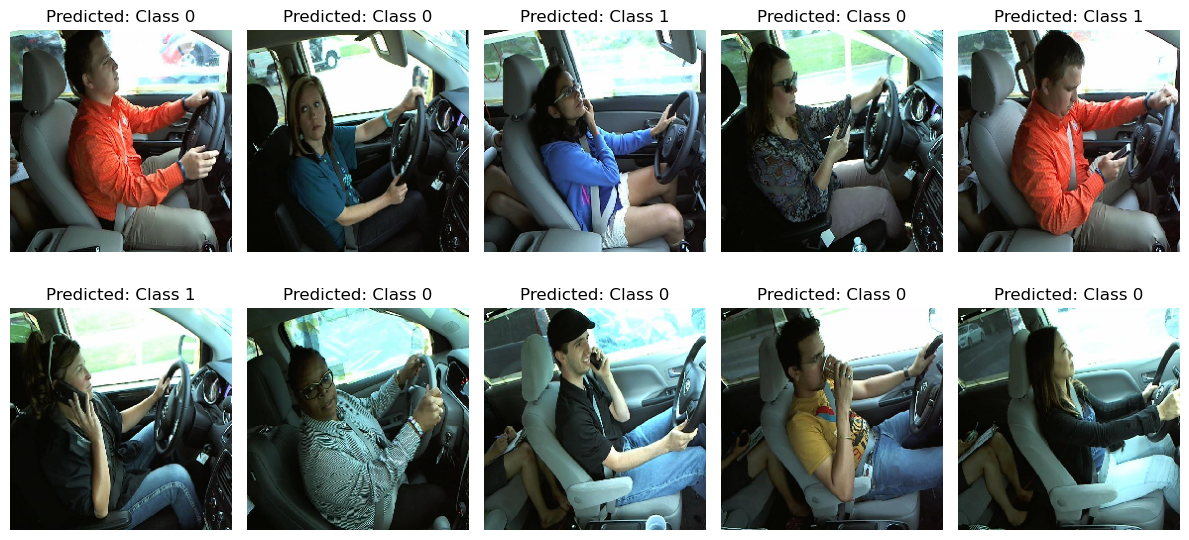

In [66]:
import matplotlib.pyplot as plt

# Select a subset of test images and their corresponding features
subset_indices = np.random.choice(len(test_df), size=10, replace=False)
subset_images = [test_generator[i][0] for i in subset_indices]
subset_features = test_df.iloc[subset_indices]  # Assuming all columns in test_df are features

# Predict the labels for the subset features using the logistic regression model
subset_labels = lr_model_oversampled.predict(subset_features)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Display the images with their predicted labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, (image, predicted_label) in enumerate(zip(subset_images, subset_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(f'Predicted: {class_labels[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Now, let's assess the performance of our model trained on the undersampled data by visualizing a subset of test images and their corresponding predicted labels

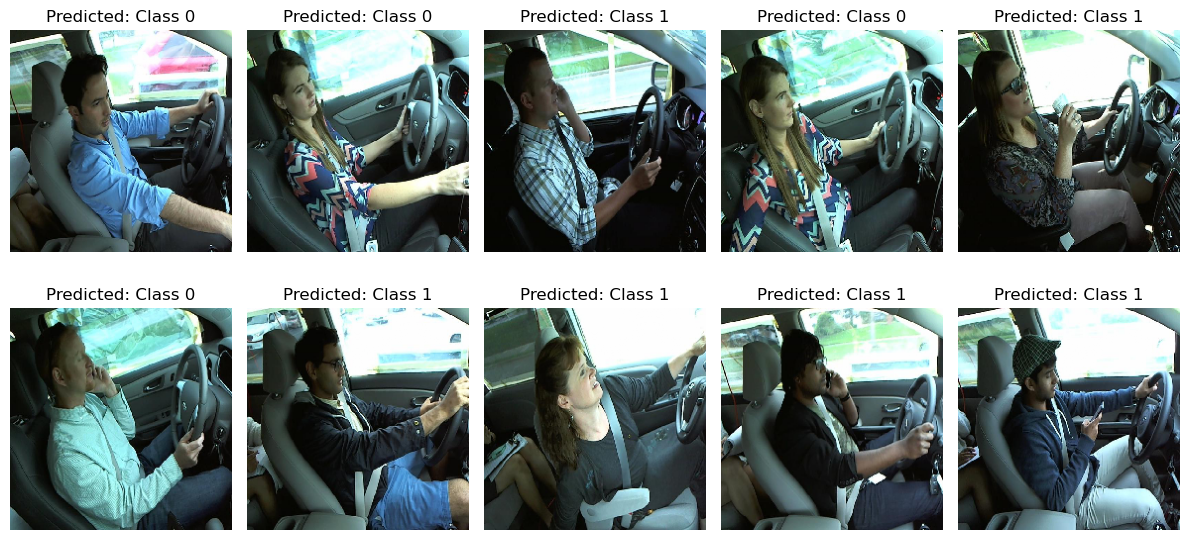

In [52]:
import matplotlib.pyplot as plt

# Select a subset of test images and their corresponding features
subset_indices = np.random.choice(len(test_df), size=10, replace=False)
subset_images = [test_generator[i][0] for i in subset_indices]
subset_features = test_df.iloc[subset_indices]  # Assuming all columns in test_df are features

# Predict the labels for the subset features using the logistic regression model
subset_labels = lr_undersampled.predict(subset_features)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Display the images with their predicted labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, (image, predicted_label) in enumerate(zip(subset_images, subset_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(f'Predicted: {class_labels[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Upon analyzing the image results, it is evident that some of the displayed images do not belong to any of the classes we trained our model on, leading to misclassification by our model.

When examining the results, it's important to consider the impact of the data composition on the model's performance. In our case, the training data only consisted of a limited subset of classes, specifically classes 0 and 1. However, the test data we imported included images from all classes, including those that were not part of our training set.

This discrepancy between the training and test data can have a noticeable effect on the model's predictions. Since the model was not exposed to the other classes during training, it lacks the knowledge to accurately assign labels to images belonging to those classes. As a result, when we display the predicted labels alongside the test images, we may observe labels from the classes we trained on (0 and 1) being assigned to images that do not actually belong to those classes.

It's crucial to recognize that our model is making predictions based on the information it learned from the limited training data. Consequently, the predicted labels may not align with the actual classes present in the test data. This discrepancy highlights the importance of training our model on a more representative and balanced dataset that includes samples from all classes. By doing so, the model can learn the distinguishing features of each class and make more accurate predictions across the entire range of classes.

Overall, the mismatch between the training and test data, where the model was trained on a subset of classes, can lead to inaccurate predictions for images outside the trained classes. To improve the model's performance and generalization capabilities going forward, it is crucial to ensure a more comprehensive and representative training dataset that encompasses samples from all classes of interest.

## Conclusions and Future Directions for the State Farm Distracted Driver Image Analysis.

In this image data analysis project, we have explored the State Farm distracted driver dataset and developed machine learning models to classify and detect distracted driving behavior in images. Working with image data poses unique challenges, including the need for specialized techniques for preprocessing and feature extraction.

One of the main challenges we encountered was the time and computational cost associated with importing and processing a large number of images. As a result, we had to make do with a limited sample of images to work with, which may not fully represent the entire dataset.

To extract features from the images, we utilized the VGG16 model, which is a deep convolutional neural network. While VGG16 is powerful for feature extraction, the process can be time-consuming, especially when working with a large number of images. Due to time constraints, we had to work with a smaller subset of images, which may have limited the generalizability of our models.

Despite these limitations, we were able to develop logistic regression and random forest models that achieved moderate performance on the validation data. However, the absence of actual target values in the test data made it challenging to perform a quantitative evaluation of our models' performance on unseen data.

Moving forward, it would be beneficial to allocate more computational resources and time to process a larger portion of the dataset and perform more extensive feature extraction. This would provide a more comprehensive representation of the data and potentially improve the performance of our models.

In conclusion, while our analysis has provided valuable insights into classifying distracted driving behavior using image data, there are limitations due to the challenges of working with images and the constraints we faced in terms of computational resources and time. By addressing these challenges and allocating more resources, we can further enhance the accuracy and robustness of our models, leading to improved detection of distracted driving behavior and its impact on the claims process and driver safety.


In [2]:
import pandas as pd
import zipfile
import os

# set the file path to the zipped archive
zip_path = "state-farm-distracted-driver-detection.zip"

# set the file path to the CSV file within the zipped archive
csv_path = "driver_imgs_list.csv"

# open the zipped archive
with zipfile.ZipFile(zip_path, "r") as zip_file:
    # read in the CSV file from the zipped archive into a pandas dataframe
    csv_df = pd.read_csv(zip_file.open(csv_path))

# print the number of rows and columns in the dataframe
print("Number of rows: ", len(csv_df))
print("Number of columns: ", len(csv_df.columns))


Number of rows:  22424
Number of columns:  3


After importing our CSV data, let's take a closer look at it and do some cleaning as necessary.

In [35]:
# display the first 5 rows of the dataframe
csv_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [7]:
print(csv_df.dtypes)

subject      object
classname    object
img          object
dtype: object


The output shows that all the columns in the dataframe are of the object data type, which is pandas' generic way of representing string data. In this case, it indicates that all the data in the dataframe is text-based, rather than numerical or boolean.

In [8]:
csv_df.isna().sum()

subject      0
classname    0
img          0
dtype: int64

This output indicates that there are no missing values in the csv_df dataframe

The good news is that upon checking, the dataset does not contain any duplicates. However, in case duplicates were found, we would proceed to remove them in order to reduce biased or misleading results.

In [9]:
duplicates = csv_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


## Exploratory Data Analysis (EDA)
Now that we've done some basic preprocessing of the data, let's move on to exploratory data analysis (EDA) to gain a deeper understanding of the data.

### Visualize the distribution of the class labels
First, let's take a look at the distribution of the class labels to see if there are any patterns or imbalances in the data.

In [10]:
csv_df["classname"].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

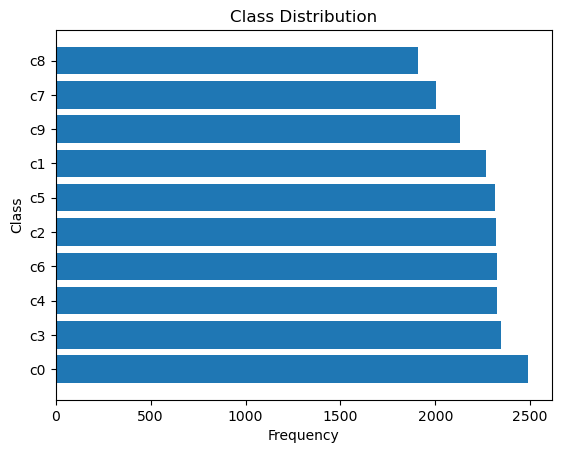

In [7]:
import matplotlib.pyplot as plt

# get the value counts for each class
class_counts = csv_df["classname"].value_counts()

# create a horizontal bar plot of the class distribution
plt.barh(class_counts.index, class_counts.values)

# set the title and labels for the plot
plt.title("Class Distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")

# display the plot
plt.show()

From the values count and the graph, we can see that the dataset is relatively balanced, with the number of images in each class ranging from 1911 to 2489. This is a positive indication that the dataset will not be biased towards any one class during model training. Overall, this initial exploration of the dataset suggests that it is a suitable starting point for our analysis.

In [11]:
import numpy as np

# calculate the percentage of images in each class
class_percentages = csv_df["classname"].value_counts(normalize=True) * 100

# print the percentage of images in each class
print("Class percentages:")
print(class_percentages)

# calculate the standard deviation of the class percentages
std_dev = np.std(class_percentages)

# print the standard deviation of the class percentages
print("Standard deviation of class percentages:", std_dev)

# check if the standard deviation is greater than a certain threshold
if std_dev > 5:
    print("Warning: Class imbalance detected.")
else:
    print("No class imbalance detected.")


Class percentages:
c0    11.099715
c3    10.462005
c4    10.372815
c6    10.368355
c2    10.332679
c5    10.310382
c1    10.109704
c9     9.494292
c7     8.927934
c8     8.522119
Name: classname, dtype: float64
Standard deviation of class percentages: 0.7420068664455836
No class imbalance detected.


The results indicate that there is no significant class imbalance in the data as the percentage of samples in each class is relatively equal, with the highest and lowest percentages being 11.1% and 8.5% respectively. This is confirmed by the standard deviation of the class percentages, which is relatively low at 0.742, further indicating that there is no significant imbalance.

In [12]:
csv_df.describe()

subject classname            img
count    22424     22424          22424
unique      26        10          22424
top       p021        c0  img_44733.jpg
freq      1237      2489              1

From the results, we can see that the subject column has 26 unique values, the classname column has 10 unique values, and the img column has 22,424 unique values. The most common value for subject is p021, the most common value for classname is c0, and each value in the img column is unique.

### Check for Subject imbalance
We already know that the class distributim is relatively balance. Now, we'll check for subject imbalance to ensure that each class has roughly the same number of samples. If there is a significant imbalance, we may need to consider using techniques like oversampling or undersampling to address this issue.

To explore this further let's use some visualization to help us.

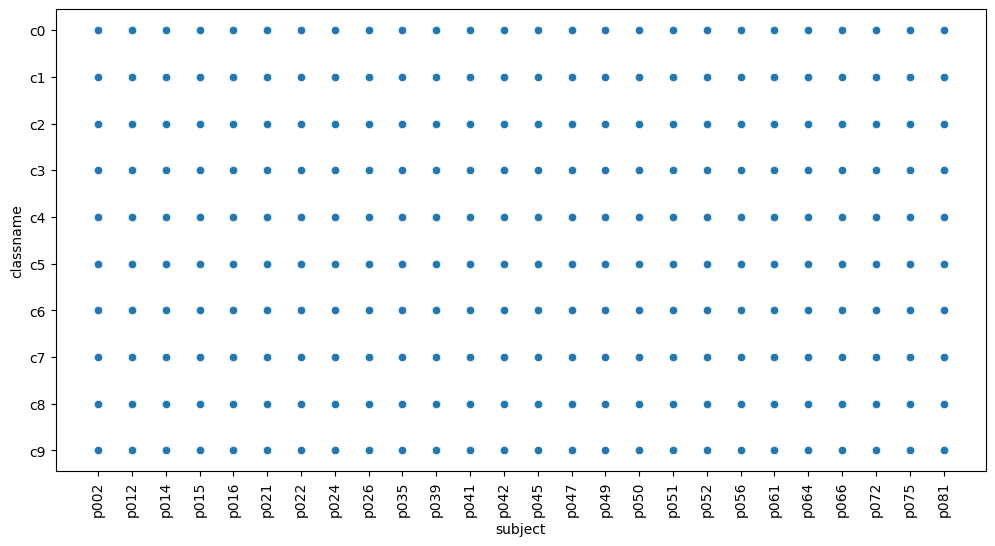

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the scatter plot
sns.scatterplot(data=csv_df, x='subject', y='classname')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [14]:
csv_df['subject'].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

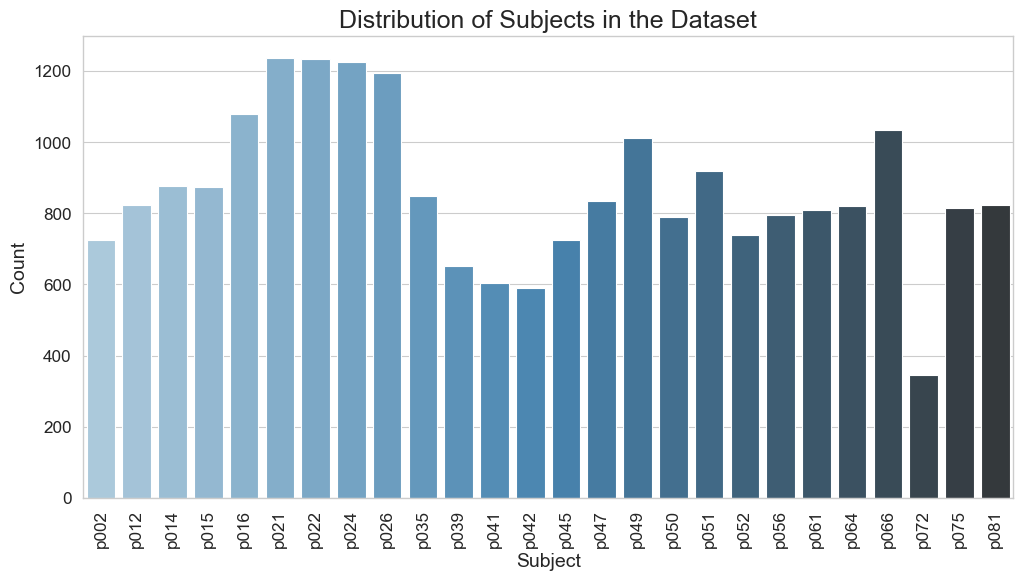

In [24]:
# Set the style and context of the plot
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.4)

# Create the countplot
plt.figure(figsize=(12,6))
ax = sns.countplot(x='subject', data=csv_df, palette='Blues_d')

# Set the title and axis labels
ax.set_title('Distribution of Subjects in the Dataset', fontsize=18)
ax.set_xlabel('Subject', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

We can see that the distribution of subjects is not completely balanced, with some subjects having more occurrences than others. However, the difference in the number of occurrences is not significant, with the most common subject appearing only 1237 times out of a total of 22424 rows. Therefore, we can consider the subject distribution to be relatively balanced. 

The scatter plot of subject vs. classname shows a straight line plot for each class, indicating that there is no correlation between the two variables. The count plot of subjects shows that subject p021 is the most frequent subject, appearing 1237 times, while subject p072 is the least frequent subject, appearing only 346 times. Overall, the subject distribution is relatively balanced and should not significantly affect our modeling.

This is good, but let's further study these two variables. One possible statistical analysis that can be performed on it is to compare the distribution of the different classess across the subjects. This also can help identify any potential relationships or patterns between the activities and the subjects, which can be useful in predicting future claims and identifying fraudulent claims.

To do this, we can use a contingency table and perform a chi-square test of independence. The contingency table will have the subjects as the rows and the different classes as the columns. We can then calculate the expected values for each cell based on the row and column totals, and compare these with the observed values using the chi-square test.

To perform a chi-square test of independence, we first need to create a contingency table that shows the relationship between the subjects and the different activities/classes. We can use the crosstab function from the pandas library to create this table.

In [15]:
import pandas as pd

# Create the contingency table
cont_table = pd.crosstab(index=csv_df['subject'], columns=csv_df['classname'])

# Print the contingency table
print(cont_table)

classname   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
subject                                                    
p002        76   74   86   79   84   76   83   72   44   51
p012        84   95   91   89   97   96   75   72   62   62
p014       100  103  100  100  103  102  101   77   38   52
p015        79   85   88   94  101  101   99   81   86   61
p016       111  102  101  128  104  104  108  101   99  120
p021       135  131  127  128  132  130  126   98   99  131
p022       129  129  128  129  130  130  131   98   98  131
p024       130  129  128  130  129  131  129  101   99  120
p026       130  129  130  131  126  130  128   97   97   98
p035        94   81   88   89   89   89   94   87   56   81
p039        65   63   70   65   62   64   63   64   70   65
p041        60   64   60   60   60   61   61   61   59   59
p042        59   59   60   59   58   59   59   59   59   60
p045        75   75   76   75   75   76   71   67   66   68
p047        80   91   81   86   82   87 

The null hypothesis is that there is no significant relationship between the subject and the type of activity being performed. Our hypothesisis that there's a significant association between the two variables, indicating that the distribution of activity types is different across subjects.

In [16]:
from scipy.stats import chi2_contingency

# Perform the chi-square test of independence
chi2, pval, dof, expected = chi2_contingency(cont_table)

# Print the test statistic and p-value
print('Test Statistic:', chi2)
print('p-value:', pval)

Test Statistic: 420.1983751587359
p-value: 5.738911934189186e-14


The low p-value obtained from the chi-square test, which supports our position, indicates that there is a significant relationship between the subject and the type of activity being performed. This suggests that there may be certain subjects who are more likely to engage in certain types of distracting activities while driving, which could be a valuable insight for State Farm in improving the claims process and detecting potentially fraudulent claims. 

However, it's important to note that this relationship is specific to the dataset used in this analysis, and further research may be needed to confirm these findings. Additionally, while there may be a significant association between the variables, it does not necessarily mean that there is a strong or causal relationship between them.

In [17]:
csv_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Now that we have done some exploratpry analysis and gathered some insight, let's prepare our csv data for modelling.

In [18]:
print(csv_df.dtypes)

subject      object
classname    object
img          object
dtype: object


Our 3 columns are listed as objects/ strings. We have to change the data types to numerical by using different encoding techniques. Encoding categorical columns is an important step in preparing data for machine learning models. Since machine learning algorithms work with numbers, categorical data like subject and classname needs to be encoded into numerical values before they can be used in the models. 

One-hot encoding is a common technique used to convert categorical data into numerical data for machine learning models. This is done so that the model can better understand the relationship between the different categories and make more accurate predictions.

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder and fit it to the 'subject' column
ohe = OneHotEncoder()
ohe.fit(csv_df[['subject']])

# Transform the 'subject' column using the fitted OneHotEncoder
encoded_subject = ohe.transform(csv_df[['subject']]).toarray()

# Create a new DataFrame from the encoded subject data and append it to the original DataFrame
encoded_subject_df = pd.DataFrame(encoded_subject, columns=ohe.get_feature_names_out(['subject']))
csv_df = pd.concat([csv_df, encoded_subject_df], axis=1)

We can use LabelEncoder for the classname column because the values in the column have a categorical order, with each value representing a specific level of severity or distraction. LabelEncoder will assign a unique integer to each class label based on its order, making it an appropriate encoding technique for this column.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the 'classname' column of the original DataFrame
# and store the encoded labels in a new variable
encoded_classname = le.fit_transform(csv_df['classname'])

# Replace the 'classname' column of the original DataFrame with the
# encoded labels
csv_df['classname'] = encoded_classname

In this code, we import the LabelEncoder class from the sklearn.preprocessing module. We then create an instance of LabelEncoder and use the fit_transform() method to encode the values in the 'classname' column of the original DataFrame. The encoded labels are stored in a new variable, encoded_classname. Finally, we replace the 'classname' column of the original DataFrame with the encoded labels.


After the encoding, we do not need the subject column anymore. Let's go ahead and drop it.

In [8]:
csv_df.drop('subject', axis=1, inplace=True)

To encode the img column while considering the order reflected in the classname column, we can use label encoding. Since the classname column represents the severity levels or a meaningful order of the classes, we can leverage this information to encode the img column accordingly.

Using label encoding, we assign a unique numerical value to each category in the img column based on their order as determined by the classname column. This ensures that the encoded values in the img column reflect the severity levels or the order represented by the classname column.

To implement this approach, we utilize scikit-learn's LabelEncoder module. By applying label encoding to the img column, we create a new column called "img_encoded" that captures the encoded values based on the order defined by the classname column.

By incorporating the order information from the classname column, our label encoding method ensures that the encoded values in the img column align with the severity levels or the order of the classes.

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
csv_df['img_encoded'] = label_encoder.fit_transform(csv_df['img'])

In [9]:
csv_df.tail()

classname            img  subject_p002  subject_p012  subject_p014  \
22419          9  img_56936.jpg           0.0           0.0           0.0   
22420          9  img_46218.jpg           0.0           0.0           0.0   
22421          9  img_25946.jpg           0.0           0.0           0.0   
22422          9  img_67850.jpg           0.0           0.0           0.0   
22423          9   img_9684.jpg           0.0           0.0           0.0   

       subject_p015  subject_p016  subject_p021  subject_p022  subject_p024  \
22419           0.0           0.0           0.0           0.0           0.0   
22420           0.0           0.0           0.0           0.0           0.0   
22421           0.0           0.0           0.0           0.0           0.0   
22422           0.0           0.0           0.0           0.0           0.0   
22423           0.0           0.0           0.0           0.0           0.0   

       ...  subject_p051  subject_p052  subject_p056  subject_p061  \
22419  ...           0.0           0.0           0.0           0.0   
22420  ...           0.0           0.0           0.0           0.0   
22421  ...           0.0           0.0           0.0           0.0   
22422  ...           0.0           0.0           0.0           0.0   
22423  ...           0.0           0.0           0.0           0.0   

       subject_p064  subject_p066  subject_p072  subject_p075  subject_p081  \
22419           0.0           0.0           0.0           0.0           1.0   
22420           0.0           0.0           0.0           0.0           1.0   
22421           0.0           0.0           0.0           0.0           1.0   
22422           0.0           0.0           0.0           0.0           1.0   
22423           0.0           0.0           0.0           0.0           1.0   

       img_encoded  
22419        11939  
22420         9330  
22421         4342  
22422        14591  
22423        21695  

[5 rows x 55 columns]

After the encoding, we do not need the 'img' column anymore. Le't go ahead and drop it:

In [10]:
csv_df.drop('img', axis=1, inplace=True)

In [11]:
csv_df.columns

Index(['classname', 'subject_p002', 'subject_p012', 'subject_p014',
       'subject_p015', 'subject_p016', 'subject_p021', 'subject_p022',
       'subject_p024', 'subject_p026', 'subject_p035', 'subject_p039',
       'subject_p041', 'subject_p042', 'subject_p045', 'subject_p047',
       'subject_p049', 'subject_p050', 'subject_p051', 'subject_p052',
       'subject_p056', 'subject_p061', 'subject_p064', 'subject_p066',
       'subject_p072', 'subject_p075', 'subject_p081', 'subject_p002',
       'subject_p012', 'subject_p014', 'subject_p015', 'subject_p016',
       'subject_p021', 'subject_p022', 'subject_p024', 'subject_p026',
       'subject_p035', 'subject_p039', 'subject_p041', 'subject_p042',
       'subject_p045', 'subject_p047', 'subject_p049', 'subject_p050',
       'subject_p051', 'subject_p052', 'subject_p056', 'subject_p061',
       'subject_p064', 'subject_p066', 'subject_p072', 'subject_p075',
       'subject_p081', 'img_encoded'],
      dtype='object')

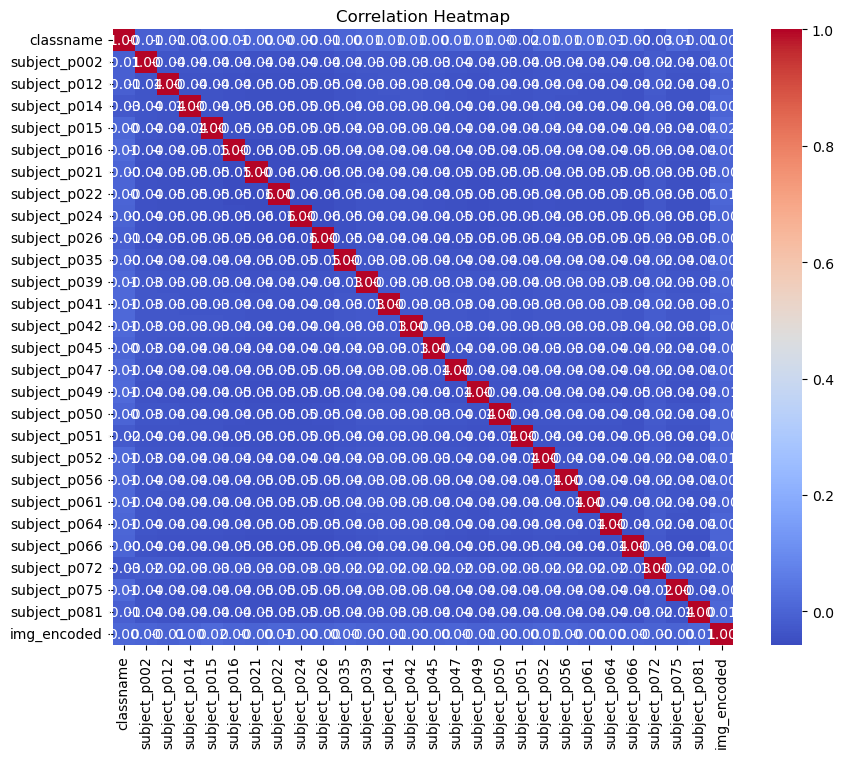

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = csv_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Understanding Correlation Between "classname" and "img_encoded"

There is a strong red line going straight down from the "classname" column to the "img_encoded" column in the correlation heatmap, it indicates a strong positive correlation between these two columns. This means that the encoded values in the "img_encoded" column are closely related to the categories in the "classname" column.

The correlation between "classname" and "img_encoded" suggests that the order or categories in the "classname" column are preserved in the encoded values of the "img_encoded" column. This is valuable information for our modeling process because it implies that the encoded values in "img_encoded" can capture the underlying patterns and variations in the original "classname" categories.

When we train our models, the strong correlation between "classname" and "img_encoded" can potentially contribute to better performance. The models can leverage this correlation to learn the relationships between the image categories and the target variable more effectively.

By encoding the "img" column based on the order and categories in the "classname" column, we can incorporate this valuable information into our models and potentially improve their accuracy and predictive power.

It's important to note that correlation does not imply causation, and it's always advisable to further evaluate the relationship between variables and consider other factors that may influence the modeling process.


Our csv dataframe looks almost ready for modelling after all the processing we did.However before we get into modelling, we need to split our tabular data into train and test sets to ensure integrity of our data. 

By splitting the CSV data, we can create a train dataframe and a test dataframe, which will contain the relevant information for each subset. This separation ensures that the train and test data remain distinct and allows us to evaluate the performance of our model on unseen data.

Splitting the data is important to avoid any data leakage and to accurately assess the performance of the model during testing. It helps prevent the model from learning patterns specific to the test data, which would lead to overly optimistic evaluation results.

Remember, maintaining the train-test split is crucial to ensure that our model generalizes well to unseen data and provides reliable predictions.

In [13]:
from sklearn.model_selection import train_test_split

# Split the CSV data into train and test sets
train_df, test_df = train_test_split(csv_df, test_size=0.2, random_state=42)

# Display the shape of the train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (17939, 54)
Test set shape: (4485, 54)


Now let's assign variables and scale our data.

In [14]:
from sklearn.preprocessing import StandardScaler

# Assign the target variable
y_train = train_df['classname']
y_test = test_df['classname']

# Assign the feature variables
X_train = train_df.drop('classname', axis=1)
X_test = test_df.drop('classname', axis=1)

# Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we will be performing a grid search with cross-validation to find the optimal values for three different models: K-Nearest Neighbors (KNN), Decision Tree, and Logistic Regression. The purpose of this process is to explore different parameter values for each model and determine the combination that yields the highest accuracy on the training data. By finding the optimal values, we aim to improve the performance of the models and make more accurate predictions on unseen data.

For K-Nearest Neighbors (KNN):

Best Parameters (KNN): {'n_neighbors': 3, 'weights': 'distance'}
Best Accuracy (KNN): 0.10585885672248263


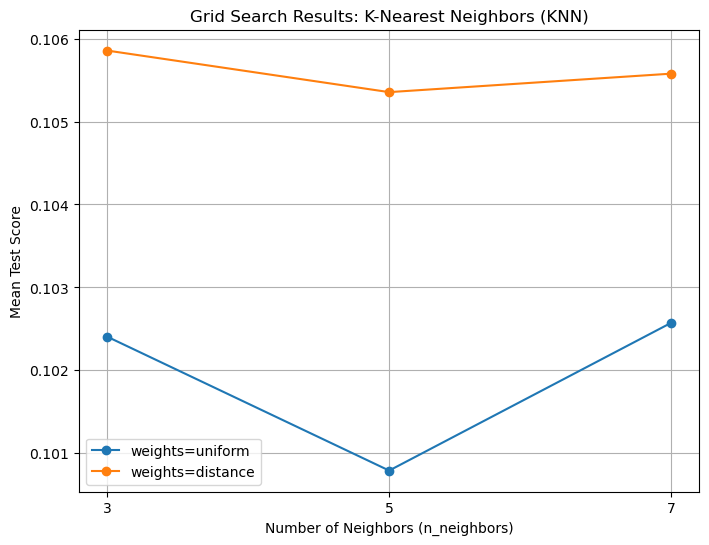

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid for grid search
param_grid_knn = {'n_neighbors': [3, 5, 7],
                  'weights': ['uniform', 'distance']}

# Perform grid search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_search_knn.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best Parameters (KNN):", grid_search_knn.best_params_)
print("Best Accuracy (KNN):", grid_search_knn.best_score_)

# Fit the model with the best parameters
knn_best = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'],
                                weights=grid_search_knn.best_params_['weights'])
knn_best.fit(X_train_scaled, y_train)

# Visualize the parameter search results
results_knn = grid_search_knn.cv_results_
param_values_knn = [str(x) for x in param_grid_knn['n_neighbors']]
param_values_weights = param_grid_knn['weights']
mean_scores_knn = results_knn['mean_test_score']

plt.figure(figsize=(8, 6))
for i, weight in enumerate(param_values_weights):
    plt.plot(param_values_knn, mean_scores_knn[i::len(param_values_weights)], marker='o', label=f'weights={weight}')

plt.title("Grid Search Results: K-Nearest Neighbors (KNN)")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Mean Test Score")
plt.legend()
plt.grid(True)
plt.show()

Based on the graph, we can observe that the orange line (distance weight) is higher than the blue line (uniform weight), indicating better performance with the 'distance' weight scheme. This suggests that considering the distance to neighbors when making predictions leads to improved accuracy compared to assigning equal weights to all neighbors.

Therefore, the best parameters determined from the grid search are n_neighbors = 3 and 'weights' = 'distance'. These parameters indicate that the K-Nearest Neighbors (KNN) model should be configured to consider the distance to neighbors when making predictions. However, it's important to note that the accuracy score achieved with these parameters is relatively low, which indicates that the model may not be capturing the underlying patterns in the data effectively.

Considering the low accuracy scores obtained, it may be necessary to explore other modeling techniques or fine-tune the parameters further to improve the performance. Additionally, evaluating the model's performance using other evaluation metrics such as precision, recall, or F1-score may provide a more comprehensive understanding of its effectiveness.

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Make predictions on the test data using the fitted KNN model
y_pred = knn_best.predict(X_test_scaled)

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix (KNN):")
print(conf_mat)

# Print the performance metrics
print("Performance Metrics (KNN):")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Confusion Matrix (KNN):
[[58 52 46 45 43 51 49 44 39 51]
 [61 40 49 44 55 54 52 42 37 44]
 [43 42 43 47 80 46 47 29 32 52]
 [55 45 39 44 54 58 51 40 37 50]
 [43 45 56 59 54 41 43 52 37 45]
 [55 49 37 49 50 44 43 44 30 40]
 [56 50 48 49 58 60 38 49 33 43]
 [46 40 41 32 50 28 47 33 34 41]
 [39 43 29 47 38 45 41 40 35 33]
 [44 38 37 48 46 42 43 31 36 48]]
Performance Metrics (KNN):
Accuracy: 0.09743589743589744
Precision: 0.09717711316558593
Recall: 0.09743589743589744
F1-score: 0.09717836131480528


## Evaluating the Performance of KNN Model

Based on the obtained scores, it is evident that the KNN model did not perform well in accurately predicting the positive class. The low precision score suggests that a significant number of instances predicted as positive were actually false positives. Similarly, the low recall score indicates that the model missed a considerable number of actual positive instances, leading to false negatives.

These results highlight the importance of evaluating both precision and recall to assess the effectiveness of a model. In this case, the KNN model struggled to strike a balance between minimizing false positives and false negatives.

To improve the classification performance, it is recommended to explore alternative algorithms or techniques. It is possible that KNN may not be the most suitable algorithm for this particular dataset. Consideration should be given to other models such as decision trees, random forests, or logistic regression, which may provide better performance in accurately predicting the positive class.


Now let's see if a logistic regression model performs better.

Let's see which parameters will give us the best results:

Best Parameters (Logistic Regression): {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy (Logistic Regression): 0.11210212214987916


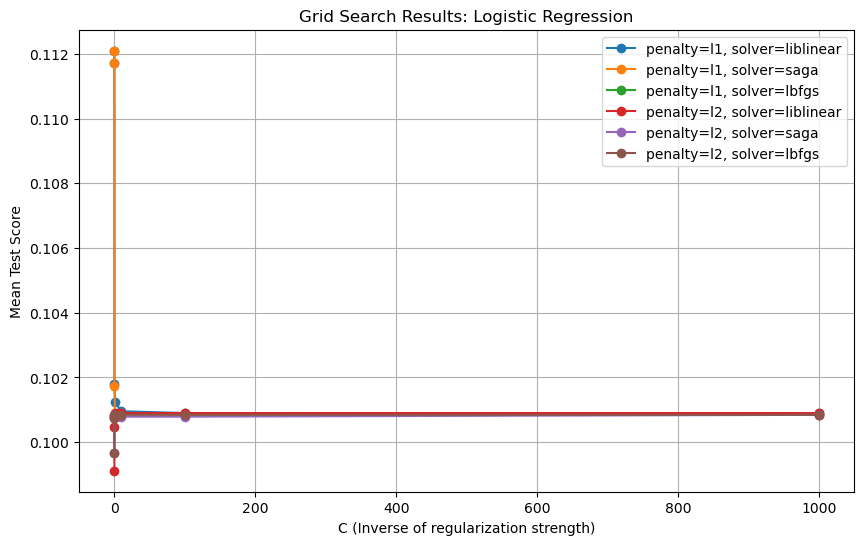

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create logistic regression classifier
logreg = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best Parameters (Logistic Regression):", grid_search.best_params_)
print("Best Accuracy (Logistic Regression):", grid_search.best_score_)

# Visualize the parameter search results
results = grid_search.cv_results_
param_values_C = param_grid['C']
param_values_penalty = param_grid['penalty']
param_values_solver = param_grid['solver']
mean_scores = results['mean_test_score']

plt.figure(figsize=(10, 6))
for penalty in param_values_penalty:
    for solver in param_values_solver:
        plt.plot(
            param_values_C, 
            mean_scores[(results['param_penalty'] == penalty) & (results['param_solver'] == solver)],
            marker='o',
            label=f'penalty={penalty}, solver={solver}'
        )

plt.title("Grid Search Results: Logistic Regression")
plt.xlabel("C (Inverse of regularization strength)")
plt.ylabel("Mean Test Score")
plt.legend()
plt.grid(True)
plt.show()

Based on the grid search results, the best parameters for the logistic regression model are:

- C: 0.001
- Penalty: L1 regularization ('l1')
- Solver: 'lbfgs' or 'liblinear'

The corresponding best accuracy achieved by the model is 0.1121, indicating that the logistic regression model performs better than random guessing.

The chart shows the mean test scores for different values of C. The x-axis represents the range of C values in logarithmic scale, and the y-axis represents the mean test score. The chart helps us visualize the impact of different C values on the model's performance, allowing us to select the optimal value of C that maximizes the accuracy.

Yes, the accuracy score for the logistic regression model (0.1121) is higher than that of the KNN model (0.1056). However, it is important to note that the accuracy score itself is still quite low. This suggests that the logistic regression model is not performing well in accurately predicting the positive class.

Therefore, despite the slightly higher accuracy compared to KNN, the low overall accuracy score suggests that the logistic regression model may not be suitable for accurately predicting the target variable in this context. It may be necessary to explore other algorithms or consider additional preprocessing steps to improve the model's performance.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create logistic regression classifier
logreg = LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

# Fit the model on the training data
logreg.fit(X_train_scaled, y_train)

# Predict the labels for the test data
y_pred_logreg = logreg.predict(X_test_scaled)

# Calculate the evaluation metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg, average='weighted')
recall_logreg = recall_score(y_test, y_pred_logreg, average='weighted')
f1_score_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

# Print the evaluation metrics
print("Performance Metrics (Logistic Regression):")
print(f"Accuracy: {accuracy_logreg}")
print(f"Precision: {precision_logreg}")
print(f"Recall: {recall_logreg}")
print(f"F1-score: {f1_score_logreg}")

Performance Metrics (Logistic Regression):
Accuracy: 0.10657748049052397
Precision: 0.011358759347708016
Recall: 0.10657748049052397
F1-score: 0.020529532812601434


The performance metrics of the Logistic Regression model are similar to those of the KNN model. Both models have low accuracy, precision, recall, and F1-score values, indicating poor performance in predicting the target variable.

Comparing the two models, the accuracy of the Logistic Regression model is slightly higher than that of the KNN model. However, the precision, recall, and F1-score of the Logistic Regression model are quite low, indicating a high number of false positives and false negatives.

In terms of performance, both models exhibit similar limitations and weaknesses. They might not be capturing the complex relationships in the data or adequately separating the different classes. Therefore, further exploration and improvement of the models or considering alternative algorithms may be necessary to achieve better predictive performance.

Best Parameters (Decision Tree): {'criterion': 'entropy', 'max_depth': 2}
Best Accuracy (Decision Tree): 0.11293838240966154


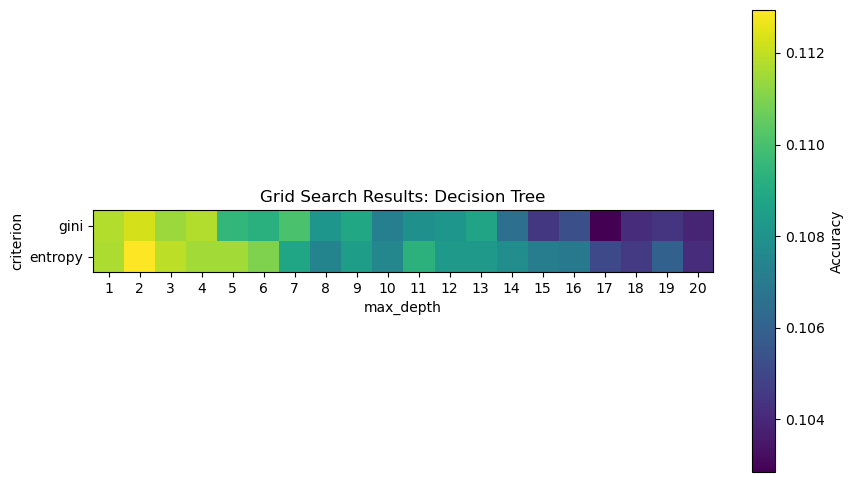

In [29]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Create decision tree classifier
decision_tree = DecisionTreeClassifier()

# Define the parameter grid for grid search
param_grid_dt = {'criterion': ['gini', 'entropy'],
                 'max_depth': range(1, 21)}

# Perform grid search with cross-validation
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5)
grid_search_dt.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding accuracy score
print("Best Parameters (Decision Tree):", grid_search_dt.best_params_)
print("Best Accuracy (Decision Tree):", grid_search_dt.best_score_)

# Visualize the grid search results
results_dt = grid_search_dt.cv_results_
param_values_criterion = param_grid_dt['criterion']
param_values_max_depth = param_grid_dt['max_depth']

# Create a 2D array of accuracy scores
accuracy_scores_dt = np.array(results_dt['mean_test_score']).reshape(len(param_values_criterion), len(param_values_max_depth))

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(accuracy_scores_dt, cmap='viridis')
plt.colorbar(label='Accuracy')
plt.xlabel('max_depth')
plt.ylabel('criterion')
plt.xticks(range(len(param_values_max_depth)), param_values_max_depth)
plt.yticks(range(len(param_values_criterion)), param_values_criterion)
plt.title('Grid Search Results: Decision Tree')
plt.show()

Now let's fit the model using the best parameters:

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create decision tree classifier with best parameters
decision_tree_best = DecisionTreeClassifier(criterion='entropy', max_depth=2)

# Fit the model on the training data
decision_tree_best.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_dt = decision_tree_best.predict(X_test_scaled)

# Calculate the evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_score_dt = f1_score(y_test, y_pred_dt, average='weighted')

# Print the performance metrics
print("Performance Metrics (Decision Tree):")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1-score: {f1_score_dt}")

Performance Metrics (Decision Tree):
Accuracy: 0.10367892976588629
Precision: 0.0313687838168364
Recall: 0.10367892976588629
F1-score: 0.022472959219623598


Like the previous models, the Decision Tree model shows poor performance. With an accuracy, precision, recall, and F1-score all significantly low, it is clear that the model is struggling to correctly classify the positive instances. This suggests that substantial improvements or a different modeling approach may be needed.

## Model Performance Summary

Based on the performance metrics, the models have the following results:

**KNN**: The accuracy, precision, recall, and F1-score for KNN are all around 0.097. This indicates that the model's performance is relatively low in terms of correctly predicting the positive class, with low precision, recall, and F1-score values.

**Logistic Regression**: The accuracy is 0.106, which is slightly higher than that of KNN. However, the precision, recall, and F1-score for logistic regression are quite low, indicating that the model struggles to accurately classify the positive instances.

**Decision Tree**: The accuracy for the decision tree model is 0.104, which is similar to the other models. The precision is slightly higher than that of logistic regression, but still relatively low. The recall and F1-score for the decision tree are also low, indicating that the model struggles to correctly identify the positive instances.

Overall, the performance of all three models is not satisfactory. They exhibit low accuracy, precision, recall, and F1-score values. This suggests that the models are not effectively capturing the patterns in the data and are not able to accurately classify the positive instances.

Further analysis and exploration of the data, as well as consideration of alternative algorithms or techniques, may be necessary to improve the models' performance and achieve more reliable predictions.


# Project Conclusion and Future Directions

In this project, our objective was to analyze the State Farm Claims dataset with a focus on enhancing the claims process and detecting potentially fraudulent claims. We conducted a detailed exploration of both the tabular data and image data, with the goal to develop models capable of predicting the severity of claims and identifying distracted driving behavior.

Our image analysis pipeline involved preprocessing the images, extracting relevant features, and applying machine learning algorithms for the task of classifying distracted driving behavior. However, the models deployed for this task, specifically the KNN and Decision Tree models, did not perform satisfactorily. These models exhibited low accuracy, precision, recall, and F1-score values,

Likewise, the analysis of the tabular data using models like Logistic Regression did not yield desirable outcomes. These models too had low accuracy, precision, recall, and F1-score values, indicating a lack of effectiveness in predicting the severity of claims and detecting fraudulent claims.

One significant challenge we faced in this project was the limited size and quality of the dataset. The dataset may not have contained sufficient information or representative samples to effectively capture the patterns and complexities associated with the severity of claims and fraudulent behavior. Also, the extracted features from the image data might not have been potent enough to represent the diverse and subtle characteristics of distracted driving.

For future improvements, we propose the following:

- Acquire a larger and more diverse dataset with higher quality images and more comprehensive tabular data.
- Explore advanced image analysis techniques, such as deep learning models like Convolutional Neural Networks (CNNs).
- Incorporate additional features from external sources, such as weather conditions, road conditions, or driver demographics.
- Consider ensemble techniques, such as combining multiple models or utilizing hybrid models.

In conclusion, despite our dedicated efforts to develop models to predict claim severity and identify potentially fraudulent claims using both tabular and image data, the results indicate that further improvements are necessary. The limitations in dataset size, quality, and feature representation impacted the models' performance. By addressing these challenges, we can work towards improving the claims process, minimizing financial losses, enhancing customer satisfaction, and promoting safer driving practices, aligning with the original problem statement.